In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
sc = spark.sparkContext
from pyspark.sql import functions as F
import pandas as pd
from pyspark.sql.functions import *

spark = SparkSession.builder.appName('BDP-GroupProject').getOrCreate()

In [9]:
#model_df = spark.read.parquet('gs://big-data-final/model-data/finalmodel1.parquet')

model_df = spark.read.parquet('gs://big-data-final/model-data/final-model-with-feature.parquet')

model_df.show(4)

+--------------------+------------+----------+----+----+------------------+------------+------------------+---------+------------+----------------------+---------------+----------------+--------------+---------------+--------------+-------------+------------------+---------------------+----------------------+--------------------+------------------+------------------+------------------+-----+------------------+-------+-------------------+----+---------+------+------+------+------+------+------+-------+---------+--------+------+--------+
|trip_start_timestamp|trip_seconds|trip_miles|fare|tips|        trip_total|payment_type|additional_charges|ride_type|trips_pooled|shared_trip_authorized|trip_start_date|trip_start_month|trip_start_day|trip_start_year|trip_start_dow|weekend_dummy|community_eventCnt|pickup_community_name|dropoff_community_name|outside_chicago_ride|  covid_cases_sma7|   covid_hosp_sma7| covid_deaths_sma7|label|          fare_add|tip_pct|     add_charge_pct|hour|rain_snow|wi

In [13]:
# check shape

model_df.count() #27 billion rows for old jb file, this should be #221,302,885

6892688

In [11]:
model_df.printSchema()

root
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- additional_charges: double (nullable = true)
 |-- ride_type: integer (nullable = true)
 |-- trips_pooled: integer (nullable = true)
 |-- shared_trip_authorized: integer (nullable = true)
 |-- trip_start_date: date (nullable = true)
 |-- trip_start_month: integer (nullable = true)
 |-- trip_start_day: integer (nullable = true)
 |-- trip_start_year: integer (nullable = true)
 |-- trip_start_dow: integer (nullable = true)
 |-- weekend_dummy: integer (nullable = true)
 |-- community_eventCnt: long (nullable = true)
 |-- pickup_community_name: string (nullable = true)
 |-- dropoff_community_name: string (nullable = true)
 |-- outside_chicago_ride: integer (nullable = true)
 |-- covid_ca

In [12]:
model_df.dtypes

[('trip_start_timestamp', 'timestamp'),
 ('trip_seconds', 'int'),
 ('trip_miles', 'double'),
 ('fare', 'double'),
 ('tips', 'double'),
 ('trip_total', 'double'),
 ('payment_type', 'string'),
 ('additional_charges', 'double'),
 ('ride_type', 'int'),
 ('trips_pooled', 'int'),
 ('shared_trip_authorized', 'int'),
 ('trip_start_date', 'date'),
 ('trip_start_month', 'int'),
 ('trip_start_day', 'int'),
 ('trip_start_year', 'int'),
 ('trip_start_dow', 'int'),
 ('weekend_dummy', 'int'),
 ('community_eventCnt', 'bigint'),
 ('pickup_community_name', 'string'),
 ('dropoff_community_name', 'string'),
 ('outside_chicago_ride', 'int'),
 ('covid_cases_sma7', 'double'),
 ('covid_hosp_sma7', 'double'),
 ('covid_deaths_sma7', 'double'),
 ('label', 'int'),
 ('fare_add', 'double'),
 ('tip_pct', 'double'),
 ('add_charge_pct', 'double'),
 ('hour', 'int'),
 ('rain_snow', 'int'),
 ('winter', 'int'),
 ('spring', 'int'),
 ('summer', 'int'),
 ('autumn', 'int'),
 ('sunday', 'int'),
 ('monday', 'int'),
 ('tuesday',

In [3]:
#df_2021 = model_df.filter(model_df.start_year == 2021)

#df_2021.show()

+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+------------------+----------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+---------+------------+----------------------+-------------------------+-----------------------+-----------+---------+----------+---------+---------+-------+--------+-------+-----------+--------------------+----+----+----+----+----+----+------------+---------------------+-------------+----------------------+------------+----------------+-----------------+----------+-----------+------------+----------------------+-------------+--------------+---------------+--------------------+
|             trip_id|trip_start_timestamp|  trip_end_timestamp|trip_seconds|trip_miles|pickup_census_tract|dropoff_census_tract|pickup

In [14]:
#df_2021.count() 7 billion rows

7838164279

In [4]:
#subset_df = df_2021.sample(0.02, seed=123)

#subset_df.show(3)

+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+------------------+----------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+---------+------------+----------------------+-------------------------+-----------------------+-----------+---------+----------+---------+---------+-------+--------+-------+-----------+--------------------+----+----+----+----+----+----+------------+---------------------+-------------+----------------------+------------+----------------+-----------------+----------+-----------+------------+----------------------+-------------+--------------+---------------+--------------------+
|             trip_id|trip_start_timestamp|  trip_end_timestamp|trip_seconds|trip_miles|pickup_census_tract|dropoff_census_tract|pickup

In [6]:
#subset_df.count() #150 mill

156766398

In [8]:
#subset_df.select('PRCP').distinct().show()

+----+
|PRCP|
+----+
|0.07|
|0.84|
| 0.0|
|0.87|
|0.16|
|0.89|
|0.18|
| 0.2|
|0.66|
|0.93|
|1.08|
|3.93|
|3.96|
|1.52|
|1.16|
|2.79|
|1.31|
| 3.5|
|3.35|
|1.25|
+----+
only showing top 20 rows



In [9]:
#subset_df.select('PRCP').describe().show()

+-------+-------------------+
|summary|               PRCP|
+-------+-------------------+
|  count|          156766398|
|   mean| 0.1031569511471205|
| stddev|0.30041749625950603|
|    min|                0.0|
|    max|               4.31|
+-------+-------------------+



In [8]:
#matrix.collect()[0]["pearson({})".format(vector_col)].values

array([1.        , 0.16726556, 0.0654002 , 0.95459174, 0.00328345,
       0.16726556, 1.        , 0.08228822, 0.26069318, 0.00647361,
       0.0654002 , 0.08228822, 1.        , 0.34790396, 0.00160209,
       0.95459174, 0.26069318, 0.34790396, 1.        , 0.00401111,
       0.00328345, 0.00647361, 0.00160209, 0.00401111, 1.        ])

In [27]:
#matrix.show()

+----------------------+
|pearson(corr_features)|
+----------------------+
|  1.0              ...|
+----------------------+



In [18]:
model_df.select('tips', 'fare', 'trip_seconds', 'trip_miles', 'trip_total').describe().show()




+-------+------------------+------------------+-----------------+-----------------+------------------+
|summary|              tips|              fare|     trip_seconds|       trip_miles|        trip_total|
+-------+------------------+------------------+-----------------+-----------------+------------------+
|  count|         220167785|         220167785|        220167785|        220167785|         220167785|
|   mean|0.8218896167301888|13.967079188265483|1051.349971350259|6.203352292752918|17.900743639887054|
| stddev|2.1667008782147352|24.262900169959217|885.1765399262365| 7.22716057038055| 26.29170971545206|
|    min|               0.0|              0.01|                0|              0.0|              0.01|
|    max|             900.0|           9955.55|            86400|          3430.53|           9975.25|
+-------+------------------+------------------+-----------------+-----------------+------------------+



In [13]:
from pyspark.sql.functions import sum, col, desc

topdf = model_df.groupBy('rain_snow').avg('tip_pct').sort(desc('rain_snow'))

topdf.show()


+---------+--------------------+
|rain_snow|        avg(tip_pct)|
+---------+--------------------+
|        1|0.048557702356555134|
|        0| 0.04685177431454058|
+---------+--------------------+



In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

pd_month = topdf.toPandas()

print(pd_month)

    trip_start_month  avg(tips)  avg(PRCP)
0                 12   0.511559  11.047369
1                 11   0.491016   8.270407
2                 10   0.503728  14.712058
3                  9   0.518257  14.872606
4                  8   0.473466   5.799754
5                  7   0.504062  16.659226
6                  6   0.534216  21.066545
7                  5   0.406704  36.699435
8                  4   0.316001  23.457679
9                  3   0.324171   0.159993
10                 2   0.574834   5.549093
11                 1   0.486528   8.273248


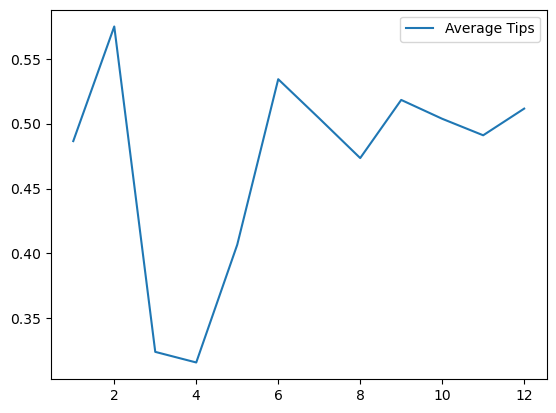

In [23]:
plt.plot(pd_month['trip_start_month'], pd_month['avg(tips)'], label='Average Tips')
#plt.plot(pd_month['trip_start_month'], pd_month['avg(PRCP)'], label='Average Precipitation')

plt.legend()
plt.show()

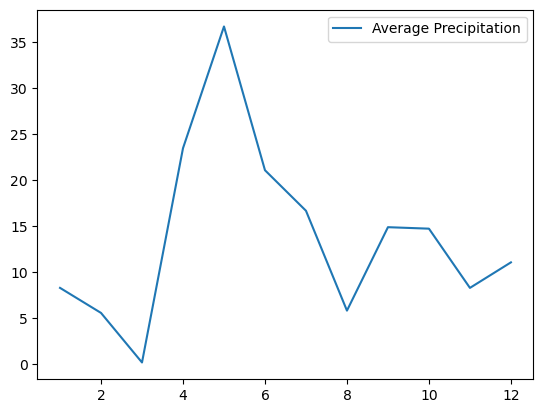

In [24]:
#plt.plot(pd_month['trip_start_month'], pd_month['avg(tips)'], label='Average Tips')
plt.plot(pd_month['trip_start_month'], pd_month['avg(PRCP)'], label='Average Precipitation')

plt.legend()
plt.show()

In [30]:
model_df.groupBy('pickup_community_name').count().sort(desc('count')).show()

+---------------------+------+
|pickup_community_name| count|
+---------------------+------+
|      Near North Side|623946|
|              Missing|586366|
|       Near West Side|372339|
|             Lakeview|361556|
|            West Town|321552|
|                 Loop|292308|
|         Lincoln Park|253586|
|               Austin|211147|
|         Logan Square|187882|
|               Uptown|157385|
|          South Shore|146125|
|            Edgewater|115678|
|               O'Hare|112530|
|       North Lawndale|110398|
|        Humboldt Park|110079|
|          Rogers Park|108583|
|       Auburn Gresham|104815|
| Greater Grand Cro...|102007|
|              Chatham|100229|
|      Near South Side| 91608|
+---------------------+------+
only showing top 20 rows



In [31]:
model_df.groupBy('dropoff_community_name').count().sort(desc('count')).show()

+----------------------+------+
|dropoff_community_name| count|
+----------------------+------+
|       Near North Side|642730|
|               Missing|639077|
|        Near West Side|400149|
|              Lakeview|355307|
|             West Town|316648|
|                  Loop|310095|
|          Lincoln Park|254860|
|                Austin|205390|
|          Logan Square|182852|
|                Uptown|149609|
|           South Shore|141534|
|                O'Hare|129122|
|             Edgewater|110058|
|        North Lawndale|107933|
|         Humboldt Park|104422|
|           Rogers Park|102644|
|        Auburn Gresham|100296|
|  Greater Grand Cro...| 98960|
|               Chatham| 96356|
|       Near South Side| 88796|
+----------------------+------+
only showing top 20 rows



In [32]:
model_df.groupBy('outside_chicago_ride').count().sort(desc('count')).show()

+--------------------+-------+
|outside_chicago_ride|  count|
+--------------------+-------+
|                   1|6887873|
|                   0|   4815|
+--------------------+-------+



In [14]:
tips_look = model_df.filter(model_df.tips > 0)
tips_look.count()

47489126

In [6]:
tips_look.select('tips', 'fare', 'trip_seconds', 'trip_miles', 'trip_total').describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|              tips|              fare|      trip_seconds|       trip_miles|        trip_total|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|          47489126|          47489126|          47489126|         47489126|          47489126|
|   mean|3.8104221254774115| 16.22543276454435|1138.8997681069136|6.937682536839365|23.492623988939027|
| stddev|3.2213928312450295|13.744332008988952| 947.1066202440613|8.298395180505892|18.027718403946693|
|    min|              0.01|              0.01|                 0|              0.0|              0.02|
|    max|             900.0|            5175.0|             86367|          3430.53|            5190.0|
+-------+------------------+------------------+------------------+-----------------+------------------+



In [8]:
tips_look.groupBy('pickup_community_name').count().sort(desc('count')).show()

+---------------------+-------+
|pickup_community_name|  count|
+---------------------+-------+
|      Near North Side|9032004|
|                 Loop|6607024|
|               O'Hare|3946811|
|       Near West Side|3934854|
|              Missing|3933049|
|             Lakeview|2761720|
|            West Town|2167014|
|         Lincoln Park|1974986|
|         Logan Square|1368426|
|      Near South Side|1228642|
|       Garfield Ridge|1090417|
|               Uptown| 981259|
|            Edgewater| 754192|
|         North Center| 541908|
|       Lincoln Square| 519730|
|          Rogers Park| 502830|
|            Hyde Park| 489478|
|             Avondale| 422232|
|          Irving Park| 418300|
|      Lower West Side| 353540|
+---------------------+-------+
only showing top 20 rows



In [9]:
tips_look.groupBy('dropoff_community_name').count().sort(desc('count')).show()

+----------------------+-------+
|dropoff_community_name|  count|
+----------------------+-------+
|       Near North Side|8983312|
|                  Loop|6180739|
|               Missing|4429714|
|        Near West Side|4091280|
|                O'Hare|3327781|
|              Lakeview|2874367|
|             West Town|2274895|
|          Lincoln Park|2187587|
|          Logan Square|1376059|
|       Near South Side|1315069|
|        Garfield Ridge| 971985|
|                Uptown| 971583|
|             Edgewater| 748247|
|          North Center| 567582|
|        Lincoln Square| 545622|
|             Hyde Park| 512425|
|           Rogers Park| 493534|
|           Irving Park| 416647|
|              Avondale| 412651|
|       Lower West Side| 352905|
+----------------------+-------+
only showing top 20 rows



In [11]:
tips_look.groupBy('outside_chicago_ride').count().sort(desc('count')).show()

+--------------------+--------+
|outside_chicago_ride|   count|
+--------------------+--------+
|                   1|46854332|
|                   0|  634794|
+--------------------+--------+



In [15]:
tips_no = model_df.filter(model_df.tips == 0)
tips_no.count()

172678659

In [14]:
tips_no.select('tips', 'fare', 'trip_seconds', 'trip_miles', 'trip_total').describe().show()

+-------+---------+------------------+-----------------+-----------------+------------------+
|summary|     tips|              fare|     trip_seconds|       trip_miles|        trip_total|
+-------+---------+------------------+-----------------+-----------------+------------------+
|  count|172678659|         172678659|        172678659|        172678659|         172678659|
|   mean|      0.0|13.345999327224455|1027.272512366453|6.001400866391827|16.362895755799286|
| stddev|      0.0|26.397835161854704|865.8192506837358|6.889764915922563|27.946647072751986|
|    min|      0.0|              0.01|                0|              0.0|              0.01|
|    max|      0.0|           9955.55|            86400|          3188.11|           9975.25|
+-------+---------+------------------+-----------------+-----------------+------------------+



In [15]:
tips_no.groupBy('pickup_community_name').count().sort(desc('count')).show()

+---------------------+--------+
|pickup_community_name|   count|
+---------------------+--------+
|      Near North Side|27023451|
|                 Loop|14366606|
|       Near West Side|13792845|
|              Missing|11970038|
|             Lakeview|10544225|
|            West Town| 9359508|
|         Lincoln Park| 8526236|
|               O'Hare| 5410435|
|         Logan Square| 5298304|
|               Uptown| 3440882|
|      Near South Side| 3089497|
|               Austin| 2705263|
|            Edgewater| 2323648|
|            Hyde Park| 2256909|
|      Lower West Side| 1979604|
|          Rogers Park| 1976590|
|          South Shore| 1862377|
|       Garfield Ridge| 1781372|
|         North Center| 1724952|
|             Avondale| 1688914|
+---------------------+--------+
only showing top 20 rows



In [16]:
tips_no.groupBy('dropoff_community_name').count().sort(desc('count')).show()

+----------------------+--------+
|dropoff_community_name|   count|
+----------------------+--------+
|       Near North Side|25984188|
|                  Loop|15140767|
|        Near West Side|14135909|
|               Missing|13529471|
|              Lakeview|10437480|
|             West Town| 9035353|
|          Lincoln Park| 8471826|
|                O'Hare| 5918707|
|          Logan Square| 5167510|
|                Uptown| 3355745|
|       Near South Side| 3143905|
|                Austin| 2618353|
|             Edgewater| 2296164|
|             Hyde Park| 2289134|
|       Lower West Side| 1918756|
|           Rogers Park| 1908352|
|        Garfield Ridge| 1869825|
|           South Shore| 1774090|
|          North Center| 1758865|
|              Avondale| 1619255|
+----------------------+--------+
only showing top 20 rows



In [17]:
tips_no.groupBy('outside_chicago_ride').count().sort(desc('count')).show()

+--------------------+---------+
|outside_chicago_ride|    count|
+--------------------+---------+
|                   1|171731786|
|                   0|   946873|
+--------------------+---------+



In [47]:
#model_df.groupBy('trip_start_year').count().show()

+---------------+-------+
|trip_start_year|  count|
+---------------+-------+
|           2022|   1008|
|           2020|6855290|
|           2021|  36390|
+---------------+-------+



In [18]:
tips_look.groupBy('pickup_community_name').avg('tips').sort(desc('avg(tips)')).show()

+---------------------+------------------+
|pickup_community_name|         avg(tips)|
+---------------------+------------------+
|               O'Hare| 7.477995840185823|
|       Garfield Ridge| 6.527886762587122|
|              Missing| 5.423975246685207|
|            East Side| 4.178343075992744|
|            Riverdale| 4.098897557232383|
|            Hegewisch|4.0666798876218815|
|              Beverly|3.9634647578485733|
|      Mount Greenwood|3.8172650832993438|
|        South Chicago|3.7571760154738882|
|          Morgan Park|  3.74266710820026|
|              Pullman|3.7374097676843747|
|            Hyde Park| 3.673022689477362|
|        South Deering|3.6659441264025645|
|         West Pullman| 3.616775660862757|
|          Edison Park| 3.608973678239165|
|       North Lawndale| 3.606434540681317|
|      Near South Side|3.5723201876543396|
|      Calumet Heights| 3.569620553359683|
|   Washington Heights|3.5686358113034324|
|          Forest Glen| 3.566075456648321|
+----------

In [19]:
tips_look.groupBy('dropoff_community_name').avg('tips').sort(desc('avg(tips)')).show()

+----------------------+------------------+
|dropoff_community_name|         avg(tips)|
+----------------------+------------------+
|                O'Hare| 6.718594309541464|
|        Garfield Ridge|  6.08078630843068|
|               Missing| 6.055070862362732|
|             East Side| 4.497721074089695|
|               Beverly| 4.295680481386889|
|             Hegewisch| 4.190237613751265|
|       Mount Greenwood| 4.036934887510183|
|             Riverdale| 4.031415554414784|
|           Morgan Park| 3.904444471328333|
|           Edison Park| 3.860045651385541|
|           Forest Glen| 3.845279422382671|
|              Clearing| 3.839466573873173|
|         South Chicago| 3.831855358684064|
|         South Deering| 3.831244487563945|
|          West Pullman| 3.746063658340048|
|               Pullman|3.7386303528220126|
|        Jefferson Park|3.7302811532233977|
|          Norwood Park|3.7163122793763272|
|             Hyde Park|3.7105080743523455|
|               Ashburn| 3.63445

In [20]:
model_df.groupBy('hour').avg('tips').sort(desc('avg(tips)')).show()

+----+------------------+
|hour|         avg(tips)|
+----+------------------+
|   5|1.0058812812790365|
|  12|0.8992012120457128|
|  13|0.8977753294421111|
|  15|0.8914369437087061|
|  17|0.8867805060709035|
|  16|0.8847501945942092|
|   6|0.8840242866988498|
|   4| 0.882025140171386|
|  11|0.8784606418608706|
|  14| 0.875082159344644|
|  18|0.8443981903423299|
|  10|0.8408910887226492|
|  20|0.8200283439570659|
|  19|0.8178371907156722|
|  21| 0.796764365123585|
|   9|0.7784377314317208|
|   7|0.7616357254308722|
|  22|0.7513639202353803|
|   8|0.7398128053358356|
|  23| 0.713894286449513|
+----+------------------+
only showing top 20 rows



In [21]:
model_df.groupBy('rain_snow').avg('tips').sort(desc('avg(tips)')).show()

+---------+------------------+
|rain_snow|         avg(tips)|
+---------+------------------+
|        1|0.8333676183717085|
|        0|0.7809984058087315|
+---------+------------------+



In [23]:
print(model_df.groupBy('rain_snow').avg('tips').sort(desc('avg(tips)')).show())

+---------+------------------+
|rain_snow|         avg(tips)|
+---------+------------------+
|        1|0.8333676183717085|
|        0|0.7809984058087315|
+---------+------------------+

None


In [33]:
#check avg tip, count of rides to see if there is a noticeable difference

variables = ['label', 'rain_snow', 'winter', 'spring', 'summer', 'autumn', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'trip_start_month', 'trip_start_year', 'trip_start_dow']

for i in variables:
    loop1 = model_df.groupBy(i).avg('tips').sort(desc('avg(tips)'))
    loop2 = model_df.groupBy(i).count().sort(desc('count'))
    loop3 = model_df.groupBy(i).avg('fare').sort(desc('avg(fare)'))
    print(loop1.show())
    print(loop2.show())
    print(loop3.show())

    

+-----+-----------------+
|label|        avg(tips)|
+-----+-----------------+
|    1|3.810422125477412|
|    0|              0.0|
+-----+-----------------+

None


+-----+---------+
|label|    count|
+-----+---------+
|    0|172678659|
|    1| 47489126|
+-----+---------+

None


+-----+------------------+
|label|         avg(fare)|
+-----+------------------+
|    1|16.225432764544355|
|    0|13.345999327224455|
+-----+------------------+

None


+---------+------------------+
|rain_snow|         avg(tips)|
+---------+------------------+
|        1|0.8333676183717083|
|        0|0.7809984058087314|
+---------+------------------+

None


+---------+---------+
|rain_snow|    count|
+---------+---------+
|        1|171912597|
|        0| 48255188|
+---------+---------+

None


+---------+------------------+
|rain_snow|         avg(fare)|
+---------+------------------+
|        1|14.052225419757917|
|        0|13.663739580912974|
+---------+------------------+

None


+------+------------------+
|winter|         avg(tips)|
+------+------------------+
|     0|0.8650154177804174|
|     1|0.6981693875941569|
+------+------------------+

None


+------+---------+
|winter|    count|
+------+---------+
|     0|163259556|
|     1| 56908229|
+------+---------+

None


+------+------------------+
|winter|         avg(fare)|
+------+------------------+
|     0|14.509211462390706|
|     1| 12.41179841565623|
+------+------------------+

None


+------+------------------+
|spring|         avg(tips)|
+------+------------------+
|     0|0.8266625522693097|
|     1| 0.805606849491948|
+------+------------------+

None


+------+---------+
|spring|    count|
+------+---------+
|     0|170259850|
|     1| 49907935|
+------+---------+

None


+------+------------------+
|spring|         avg(fare)|
+------+------------------+
|     1|14.713774333279837|
|     0|13.748201908846884|
+------+------------------+

None


+------+------------------+
|summer|         avg(tips)|
+------+------------------+
|     1|0.8984627845057573|
|     0|0.7951860911645913|
+------+------------------+

None


+------+---------+
|summer|    count|
+------+---------+
|     0|163240555|
|     1| 56927230|
+------+---------+

None


+------+------------------+
|summer|         avg(fare)|
+------+------------------+
|     1|14.827789342815299|
|     0|13.666921884025758|
+------+------------------+

None


+------+------------------+
|autumn|         avg(tips)|
+------+------------------+
|     1|0.8838174466074237|
|     0|0.8005498850841423|
+------+------------------+

None


+------+---------+
|autumn|    count|
+------+---------+
|     0|163743394|
|     1| 56424391|
+------+---------+

None


+------+------------------+
|autumn|         avg(fare)|
+------+------------------+
|     1|14.006856607809707|
|     0| 13.95337227393736|
+------+------------------+

None


+------+------------------+
|sunday|         avg(tips)|
+------+------------------+
|     0|0.8247415624669721|
|     1|0.8034396670927635|
+------+------------------+

None


+------+---------+
|sunday|    count|
+------+---------+
|     0|190691226|
|     1| 29476559|
+------+---------+

None


+------+------------------+
|sunday|         avg(fare)|
+------+------------------+
|     1|14.690575921022475|
|     0|13.855242925125447|
+------+------------------+

None


+------+------------------+
|monday|         avg(tips)|
+------+------------------+
|     1|0.8794861477621091|
|     0|0.8140816393401161|
+------+------------------+

None


+------+---------+
|monday|    count|
+------+---------+
|     0|193884198|
|     1| 26283587|
+------+---------+

None


+------+-----------------+
|monday|        avg(fare)|
+------+-----------------+
|     1|14.41186764005985|
|     0|13.90678218577667|
+------+-----------------+

None


+-------+------------------+
|tuesday|         avg(tips)|
+-------+------------------+
|      1|0.8384519221206622|
|      0|0.8195265543643592|
+-------+------------------+

None


+-------+---------+
|tuesday|    count|
+-------+---------+
|      0|192677159|
|      1| 27490626|
+-------+---------+

None


+-------+------------------+
|tuesday|         avg(fare)|
+-------+------------------+
|      0|14.046001980649905|
|      1|13.413922653489141|
+-------+------------------+

None


+---------+------------------+
|wednesday|         avg(tips)|
+---------+------------------+
|        1|0.8517505230301836|
|        0|0.8173540219390308|
+---------+------------------+

None


+---------+---------+
|wednesday|    count|
+---------+---------+
|        0|191135999|
|        1| 29031786|
+---------+---------+

None


+---------+------------------+
|wednesday|         avg(fare)|
+---------+------------------+
|        0| 14.03541053655726|
|        1|13.517207433259445|
+---------+------------------+

None


+--------+------------------+
|thursday|         avg(tips)|
+--------+------------------+
|       1|0.8694267387692833|
|       0| 0.813841091236764|
+--------+------------------+

None


+--------+---------+
|thursday|    count|
+--------+---------+
|       0|188288584|
|       1| 31879201|
+--------+---------+

None


+--------+------------------+
|thursday|         avg(fare)|
+--------+------------------+
|       1|14.041767395926811|
|       0|13.954433703691777|
+--------+------------------+

None


+------+------------------+
|friday|         avg(tips)|
+------+------------------+
|     0| 0.822287882865406|
|     1|0.8199430966924712|
+------+------------------+

None


+------+---------+
|friday|    count|
+------+---------+
|     0|182771892|
|     1| 37395893|
+------+---------+

None


+------+------------------+
|friday|         avg(fare)|
+------+------------------+
|     1|14.117218960381477|
|     0|13.936359963379939|
+------+------------------+

None


+--------+------------------+
|saturday|         avg(tips)|
+--------+------------------+
|       0| 0.842460931473068|
|       1|0.7251564714889777|
+--------+------------------+

None


+--------+---------+
|saturday|    count|
+--------+---------+
|       0|181557652|
|       1| 38610133|
+--------+---------+

None


+--------+------------------+
|saturday|         avg(fare)|
+--------+------------------+
|       0|14.037278605696008|
|       1|13.636978242991262|
+--------+------------------+

None


+----------------+------------------+
|trip_start_month|         avg(tips)|
+----------------+------------------+
|               9|0.9274539509465238|
|              10|0.9177759454675877|
|               8|0.8853145995619398|
|               7|0.8825616193082527|
|               6|0.8779676951954073|
|              11|0.8728592583611937|
|              12|0.8569648847236719|
|               5|0.8037965445328557|
|               4|0.7281337864194316|
|               2|0.7201248131587491|
|               3|0.6896974432772581|
|               1|0.6844191440389337|
+----------------+------------------+

None


+----------------+--------+
|trip_start_month|   count|
+----------------+--------+
|              10|20233110|
|               2|19116494|
|               8|19086422|
|               9|18993550|
|               3|18933144|
|               1|18858591|
|               7|18847258|
|              12|18276604|
|              11|17914677|
|               6|17272601|
|               5|16897339|
|               4|15737995|
+----------------+--------+

None


+----------------+------------------+
|trip_start_month|         avg(fare)|
+----------------+------------------+
|               6|15.370224029953544|
|               8|14.945781683963613|
|               5| 14.80267803468933|
|               7| 14.77082397078663|
|               9|14.765746672949494|
|              10|14.384115828955558|
|               4|13.897861653914616|
|              11|13.882591043087166|
|              12|13.711016644011103|
|               3|12.903659266522222|
|               2|12.556709347435769|
|               1|11.771100429507165|
+----------------+------------------+

None


+---------------+------------------+
|trip_start_year|         avg(tips)|
+---------------+------------------+
|           2021|1.0308284985116296|
|           2019|0.7984589596542971|
|           2020|  0.61265970882496|
+---------------+------------------+

None


+---------------+---------+
|trip_start_year|    count|
+---------------+---------+
|           2019|124298673|
|           2021| 54932567|
|           2020| 40936545|
+---------------+---------+

None


+---------------+------------------+
|trip_start_year|         avg(fare)|
+---------------+------------------+
|           2021|18.793986044380144|
|           2020|12.499219969100956|
|           2019|12.317300519290336|
+---------------+------------------+

None


+--------------+------------------+
|trip_start_dow|         avg(tips)|
+--------------+------------------+
|             2| 0.879486147762109|
|             5|0.8694267387692833|
|             4|0.8517505230301836|
|             3|0.8384519221206622|
|             6|0.8199430966924713|
|             1|0.8034396670927636|
|             7|0.7251564714889777|
+--------------+------------------+

None


+--------------+--------+
|trip_start_dow|   count|
+--------------+--------+
|             7|38610133|
|             6|37395893|
|             5|31879201|
|             1|29476559|
|             4|29031786|
|             3|27490626|
|             2|26283587|
+--------------+--------+

None


+--------------+------------------+
|trip_start_dow|         avg(fare)|
+--------------+------------------+
|             1|14.690575921022473|
|             2| 14.41186764005985|
|             6|14.117218960381477|
|             5|14.041767395926811|
|             7|13.636978242991264|
|             4|13.517207433259447|
|             3|13.413922653489141|
+--------------+------------------+

None


In [26]:
model_df.groupBy('trip_start_year', 'pickup_community_name').avg('tips').sort(desc('avg(tips)')).show()

+---------------+---------------------+------------------+
|trip_start_year|pickup_community_name|         avg(tips)|
+---------------+---------------------+------------------+
|           2021|               O'Hare|3.3235319344747176|
|           2019|               O'Hare|3.1738013009923502|
|           2020|               O'Hare|2.7321090399505685|
|           2021|       Garfield Ridge|2.6983250669569903|
|           2019|       Garfield Ridge| 2.520777125984405|
|           2020|       Garfield Ridge|1.9480418571031441|
|           2021|              Missing| 1.554135252499675|
|           2019|              Missing|1.3766131677050455|
|           2021|                 Loop| 1.281391864848948|
|           2021|      Near South Side|1.2067877109850407|
|           2021|       Lincoln Square|1.1166277512672595|
|           2021|      Near North Side|1.0821113966664928|
|           2021|            Edgewater|1.0712589686886334|
|           2021|         North Center|1.061529254660549

In [27]:
model_df.groupBy('trip_start_year', 'pickup_community_name').count().sort(desc('count')).show()

+---------------+---------------------+--------+
|trip_start_year|pickup_community_name|   count|
+---------------+---------------------+--------+
|           2019|      Near North Side|22496280|
|           2019|                 Loop|14002058|
|           2019|       Near West Side|11000790|
|           2019|              Missing| 8111497|
|           2021|      Near North Side| 8091445|
|           2019|             Lakeview| 7646611|
|           2019|            West Town| 6774715|
|           2019|         Lincoln Park| 6134567|
|           2019|               O'Hare| 5539464|
|           2020|      Near North Side| 5467730|
|           2021|              Missing| 4605194|
|           2019|         Logan Square| 3945632|
|           2021|                 Loop| 3900702|
|           2021|       Near West Side| 3816529|
|           2021|             Lakeview| 3337187|
|           2020|              Missing| 3186396|
|           2020|                 Loop| 3070870|
|           2020|   

In [28]:
model_df.groupBy('trip_start_year', 'dropoff_community_name').count().sort(desc('count')).show()

+---------------+----------------------+--------+
|trip_start_year|dropoff_community_name|   count|
+---------------+----------------------+--------+
|           2019|       Near North Side|21448767|
|           2019|                  Loop|14215515|
|           2019|        Near West Side|11221016|
|           2019|               Missing| 9336280|
|           2021|       Near North Side| 8076851|
|           2019|              Lakeview| 7693005|
|           2019|             West Town| 6618226|
|           2019|          Lincoln Park| 6225170|
|           2019|                O'Hare| 5448292|
|           2020|       Near North Side| 5441882|
|           2021|               Missing| 5066619|
|           2021|                  Loop| 4037193|
|           2021|        Near West Side| 3985023|
|           2019|          Logan Square| 3883722|
|           2020|               Missing| 3556286|
|           2021|              Lakeview| 3297320|
|           2020|                  Loop| 3068798|


In [31]:
#corrlelation to tips and covid

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

subset_corr = model_df.select('fare', 'tips', 'covid_cases_sma7', 'covid_hosp_sma7', 'covid_deaths_sma7', 'label', 'rain_snow', 'winter', 'spring', 'summer', 'autumn')

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=subset_corr.columns, outputCol=vector_col)
df_vector = assembler.transform(subset_corr).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.00000000e+00,  1.66926650e-01,  2.76763210e-02,  3.47306481e-02,
        2.02999713e-02,  4.88120427e-02,  6.62375965e-03, -3.78455065e-02,
        1.66620830e-02,  2.09488512e-02,  9.62377458e-04,  1.66926650e-01,
        1.00000000e+00,  2.04157856e-03, -1.21359263e-02, -2.57113990e-02,
        7.23330505e-01,  9.99882963e-03, -3.37124245e-02, -4.06872122e-03,
        2.08700577e-02,  1.67779327e-02,  2.76763210e-02,  2.04157856e-03,
        1.00000000e+00,  8.51559799e-01,  5.69641165e-01, -2.24656254e-02,
       -2.05982652e-02, -1.31917210e-01, -1.00959451e-01, -9.52372960e-02,
        3.24621114e-01,  3.47306481e-02, -1.21359263e-02,  8.51559799e-01,
        1.00000000e+00,  8.52114229e-01, -4.46262069e-02, -2.46706040e-03,
       -1.54306977e-01,  1.53456948e-02, -1.13072983e-01,  2.53422454e-01,
        2.02999713e-02, -2.57113990e-02,  5.69641165e-01,  8.52114229e-01,
        1.00000000e+00, -5.18524149e-02,  6.66829018e-03, -1.01262841e-01,
        1.02193769e-01, -

In [32]:
print(matrix.collect()[0]["pearson({})".format(vector_col)].values)

[ 1.00000000e+00  1.66926650e-01  2.76763210e-02  3.47306481e-02
  2.02999713e-02  4.88120427e-02  6.62375965e-03 -3.78455065e-02
  1.66620830e-02  2.09488512e-02  9.62377458e-04  1.66926650e-01
  1.00000000e+00  2.04157856e-03 -1.21359263e-02 -2.57113990e-02
  7.23330505e-01  9.99882963e-03 -3.37124245e-02 -4.06872122e-03
  2.08700577e-02  1.67779327e-02  2.76763210e-02  2.04157856e-03
  1.00000000e+00  8.51559799e-01  5.69641165e-01 -2.24656254e-02
 -2.05982652e-02 -1.31917210e-01 -1.00959451e-01 -9.52372960e-02
  3.24621114e-01  3.47306481e-02 -1.21359263e-02  8.51559799e-01
  1.00000000e+00  8.52114229e-01 -4.46262069e-02 -2.46706040e-03
 -1.54306977e-01  1.53456948e-02 -1.13072983e-01  2.53422454e-01
  2.02999713e-02 -2.57113990e-02  5.69641165e-01  8.52114229e-01
  1.00000000e+00 -5.18524149e-02  6.66829018e-03 -1.01262841e-01
  1.02193769e-01 -1.36161559e-01  1.40097089e-01  4.88120427e-02
  7.23330505e-01 -2.24656254e-02 -4.46262069e-02 -5.18524149e-02
  1.00000000e+00  7.57517

In [ ]:
#whitney look at this
#

variables = ['ride_type', 'payment_type', 'trips_pooled', 'weekend_dummy', 'label', 'rain_snow', 'winter', 'spring', 'summer', 'autumn', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'trip_start_month', 'trip_start_year', 'trip_start_dow']

for i in variables:
    loop1 = tips_look.groupBy(i).avg('tips', 'fare', 'trip_seconds', 'trip_miles', 'tip_pct').sort(desc('avg(tips)'))
    loop2 = tips_no.groupBy(i).avg('tips', 'fare', 'trip_seconds', 'trip_miles', 'tip_pct').sort(desc('avg(tips)'))
    loop3 = model_df.groupBy(i).avg('tips', 'fare', 'trip_seconds', 'trip_miles', 'tip_pct').sort(desc('avg(tips)'))
    print('Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers', loop1.show())
    print('Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers', loop2.show())
    print('Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset',loop3.show())
    



+---------+-----------------+------------------+------------------+-----------------+-------------------+
|ride_type|        avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+---------+-----------------+------------------+------------------+-----------------+-------------------+
|        0|4.117533967898551|17.379139757393805|1007.8924110394564|4.838520793939039|  0.267008163593884|
|        1|3.721080281687193|15.889808097249567|1177.0110917804827|7.548349253714558|0.21069903831941042|
+---------+-----------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+---------+---------+------------------+-----------------+------------------+------------+
|ride_type|avg(tips)|         avg(fare)|avg(trip_seconds)|   avg(trip_miles)|avg(tip_pct)|
+---------+---------+------------------+-----------------+------------------+------------+
|        0|      0.0| 14.97949765055369|871.1583724871095|3.3679366068507415|         0.0|
|        1|      0.0|13.206565944114326|1040.598220978345|   6.2261900968202|         0.0|
+---------+---------+------------------+-----------------+------------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+---------+------------------+------------------+-----------------+-----------------+--------------------+
|ride_type|         avg(tips)|         avg(fare)|avg(trip_seconds)|  avg(trip_miles)|        avg(tip_pct)|
+---------+------------------+------------------+-----------------+-----------------+--------------------+
|        0|1.8147023130744324|16.037081174038097|931.4205531931963|4.016060592392009| 0.11767731264907348|
|        1|0.6988192999195147|13.710479125508602|1066.216573622631|6.474491736790389|0.039569303349006046|
+---------+------------------+------------------+-----------------+-----------------+--------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+------------+------------------+------------------+------------------+-------------------+-------------------+
|payment_type|         avg(tips)|         avg(fare)| avg(trip_seconds)|    avg(trip_miles)|       avg(tip_pct)|
+------------+------------------+------------------+------------------+-------------------+-------------------+
|   No Charge| 6.690714285714285|39.392681940700804| 830.1752021563342| 3.1946765498652288|0.21382700507803673|
|        Cash| 4.852279372317611|19.668963251072952|  3107.63821083691| 3.4765122049356267| 0.6163762650236462|
| Credit Card| 4.174229323596055|17.445995994642455|1010.1629063821139|  4.873625705370402|0.27059006355116444|
|     Dispute| 4.144736842105263|  8.81578947368421|154.73684210526315|0.13684210526315788| 0.5375508753812536|
|      Mobile|3.7143223365825726| 15.89253633444015|1172.9512545588711|  7.499141092317453|0.21054294322810177|
|      Prcard| 2.418568063206678|18.411764098289357|1182.9278776456945|  5.789430269643368|0.19730257075

+------------+---------+------------------+------------------+------------------+------------+
|payment_type|avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|avg(tip_pct)|
+------------+---------+------------------+------------------+------------------+------------+
|     Dispute|      0.0|16.573444857496902| 891.4448574969022| 3.919264766625361|         0.0|
|   No Charge|      0.0| 16.05659007136696| 684.4294565132146| 2.911311531121743|         0.0|
|     Prepaid|      0.0|        18.7408125|        1101.61875|6.1725249999999985|         0.0|
|     Unknown|      0.0| 21.12703211776245|1312.7931991729615|4.4882176660044415|         0.0|
|        Cash|      0.0|13.970491349666139| 812.0710122958774|2.9944480949993717|         0.0|
|      Prcard|      0.0|21.247965780855566|1352.1785958086095| 6.860494780293304|         0.0|
| Credit Card|      0.0|20.053831415532898| 950.3875497931505| 4.938873834605645|         0.0|
|      Mobile|      0.0|13.206636206460317|1040.56

+------------+--------------------+------------------+------------------+------------------+--------------------+
|payment_type|           avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|        avg(tip_pct)|
+------------+--------------------+------------------+------------------+------------------+--------------------+
| Credit Card|    3.94466731821538|17.589414068378428|1006.8755568698725| 4.877214030359823|  0.2557089459101776|
|      Mobile|  0.7059135313892282|13.717096277635884|1065.7277905967226| 6.467791853714386| 0.04001405884982408|
|   No Charge| 0.24986838462893518| 16.92808918640059| 689.8724111030023| 2.921893952739262| 0.00798548646188204|
|      Prcard|  0.1596534106881155|21.060743730374714|1341.0060946798649|6.7897921588564385|0.013024247213904801|
|       Pcard| 0.03802281368821293|11.327471482889734| 658.9733840304183| 3.043346007604562|0.005559306400662225|
|     Unknown|0.022506001084905258|20.941899201262977| 1300.652762123166| 4.438819467226

+------------+------------------+------------------+------------------+------------------+-------------------+
|trips_pooled|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|       avg(tip_pct)|
+------------+------------------+------------------+------------------+------------------+-------------------+
|           1|3.8564868354659083|16.378015345548032|1126.9536341436863| 6.897785107053453|0.22382501306950808|
|           2| 2.413797699305133|12.295810095625056| 1518.644543937061| 8.644669841228772|0.20804542486708708|
|           3|2.0402181322426722| 9.747038666602402|1601.9816478807618| 8.033516946332215|0.20888473706404392|
|          12| 1.901639344262295| 6.270491803278689|1521.5737704918033| 5.821311475409836|0.22618661460277403|
|           4|1.8943457189014539| 8.197630586968229|1535.6402907915995| 7.494300484652666|0.21107733788746083|
|          16|1.8333333333333333|              6.25|1407.8333333333333| 6.783333333333332|0.22063527090308235|
|

+------------+---------+------------------+------------------+------------------+------------+
|trips_pooled|avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|avg(tip_pct)|
+------------+---------+------------------+------------------+------------------+------------+
|          12|      0.0| 6.231306081754735|1478.9900299102692| 6.039481555333999|         0.0|
|         128|      0.0|               2.5|1059.6666666666667| 3.533333333333333|         0.0|
|        4097|      0.0|               7.5|            1259.0|               3.8|         0.0|
|           5|      0.0| 6.654932712763397|1489.7160363100795| 6.587818507359234|         0.0|
|          64|      0.0|               7.5| 669.8333333333334|2.8333333333333326|         0.0|
|          15|      0.0| 6.123595505617978| 1477.685393258427|  6.33820224719101|         0.0|
|           8|      0.0|  6.19261887620419|1478.4237718125407| 6.141482395694055|         0.0|
|           9|      0.0| 6.148859595871997|1473.37

+------------+-------------------+------------------+------------------+------------------+--------------------+
|trips_pooled|          avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|        avg(tip_pct)|
+------------+-------------------+------------------+------------------+------------------+--------------------+
|           1| 0.8682902333674154| 14.31407746546674|1021.9311026020666| 6.106177357378165|0.050394330675346086|
|           2|0.23320450085247965|10.444606762980156|1382.1415865047434| 7.732973384983045| 0.02009991536355256|
|          16|0.19642857142857142| 6.026785714285714|1307.5892857142858| 5.489285714285714| 0.02363949331104454|
|           3|0.17048923827691218|  8.40555955551481|1528.4597834038047| 7.433599146288949|0.017455290268680947|
|          15|               0.16|              6.25|           1500.51| 6.373000000000001| 0.01752289963702636|
|           4| 0.1383781691503774| 7.389361976646668|1496.6622365826909| 7.038089910800387|0.015

+-------------+------------------+------------------+-----------------+------------------+-------------------+
|weekend_dummy|         avg(tips)|         avg(fare)|avg(trip_seconds)|   avg(trip_miles)|       avg(tip_pct)|
+-------------+------------------+------------------+-----------------+------------------+-------------------+
|            0|3.8418541197738945| 16.29953017489102|1169.763109171091|7.1511767505731445|0.22478328119253418|
|            1|3.7734510860213186|16.138277674870885|1102.597591748695| 6.686565699480078|0.22174780099501004|
+-------------+------------------+------------------+-----------------+------------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+-------------+---------+------------------+------------------+-----------------+------------+
|weekend_dummy|avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+-------------+---------+------------------+------------------+-----------------+------------+
|            1|      0.0| 13.57043076255948|1001.3542646197783|5.871786356487771|         0.0|
|            0|      0.0|13.135074202899187|  1051.63099681892|6.123215159362568|         0.0|
+-------------+---------+------------------+------------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+-------------+------------------+------------------+------------------+-----------------+--------------------+
|weekend_dummy|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|        avg(tip_pct)|
+-------------+------------------+------------------+------------------+-----------------+--------------------+
|            0|0.8598327208741191|13.843300674716547|1078.0697559231705|6.353279858428937|0.050308006043228874|
|            1|0.7806362431296104|14.101656508133452|1022.2990731598017|6.040344599536991| 0.04587428493038086|
+-------------+------------------+------------------+------------------+-----------------+--------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+-----+------------------+------------------+------------------+-----------------+-------------------+
|label|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+-----+------------------+------------------+------------------+-----------------+-------------------+
|    1|3.8104221254774115|16.225432764544355|1138.8997681069136|6.937682536839362|0.22338844252785348|
+-----+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+-----+---------+------------------+-----------------+-----------------+------------+
|label|avg(tips)|         avg(fare)|avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+-----+---------+------------------+-----------------+-----------------+------------+
|    0|      0.0|13.345999327224455|1027.272512366453|6.001400866391826|         0.0|
+-----+---------+------------------+-----------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+-----+------------------+------------------+------------------+-----------------+-------------------+
|label|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+-----+------------------+------------------+------------------+-----------------+-------------------+
|    1|3.8104221254774115|16.225432764544355|1138.8997681069136|6.937682536839362|0.22338844252785345|
|    0|               0.0|13.345999327224455| 1027.272512366453|6.001400866391829|                0.0|
+-----+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+---------+-----------------+------------------+------------------+-----------------+-------------------+
|rain_snow|        avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+---------+-----------------+------------------+------------------+-----------------+-------------------+
|        1|3.834292194501365| 16.36461314892615|1142.6953761050431| 6.94904495537748|0.22341211132301977|
|        0|3.722330710126683|15.711793820436633|1124.8922476285802|6.895750042643664|0.22330109390472871|
+---------+-----------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+---------+---------+------------------+------------------+-----------------+------------+
|rain_snow|avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+---------+---------+------------------+------------------+-----------------+------------+
|        1|      0.0| 13.41006697634436|1028.6182958790455|5.999199566412036|         0.0|
|        0|      0.0|13.119929181207528| 1022.523758832057|6.009168409210439|         0.0|
+---------+---------+------------------+------------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+---------+------------------+------------------+------------------+-----------------+--------------------+
|rain_snow|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|        avg(tip_pct)|
+---------+------------------+------------------+------------------+-----------------+--------------------+
|        1|0.8333676183717083|14.052225419757914|1053.4124794822337|6.205644550119452| 0.04855770235655515|
|        0|0.7809984058087314|13.663739580912974| 1044.002136972298|6.195185960108543|0.046851774314540594|
+---------+------------------+------------------+------------------+-----------------+--------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+------+-----------------+------------------+------------------+-----------------+-------------------+
|winter|        avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+------+-----------------+------------------+------------------+-----------------+-------------------+
|     0|3.941671279172134|16.801879998016616|1165.7071306994387|7.092405998689354| 0.2223565803127785|
|     1| 3.40717013853141|14.454347117715821|1056.5364009848756|6.462307712229344|0.22655875240607415|
+------+-----------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+------+---------+------------------+------------------+------------------+------------+
|winter|avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|avg(tip_pct)|
+------+---------+------------------+------------------+------------------+------------+
|     1|      0.0|11.885388455838031| 988.7022893486939|5.6562741155718586|         0.0|
|     0|      0.0|13.864617552469221|1040.9676182982496| 6.123944814613121|         0.0|
+------+---------+------------------+------------------+------------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+------+------------------+------------------+------------------+-----------------+-------------------+
|winter|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+------+------------------+------------------+------------------+-----------------+-------------------+
|     0|0.8650154177804174|14.509211462390706|1068.3421997362286|6.336477468001377|0.04879703470754174|
|     1| 0.698169387594157|12.411798415656229|1002.6022996955326|5.821439915833145|0.04642456319766398|
+------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+------+------------------+------------------+------------------+------------------+-------------------+
|spring|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|       avg(tip_pct)|
+------+------------------+------------------+------------------+------------------+-------------------+
|     0|3.8114012918215088|16.007692927567295|1127.6531619201514| 6.933876267993795|0.22465186576357263|
|     1|  3.80699837384692|16.986781565443533|1178.2246351287297|6.9509915310136705|0.21897075865817872|
+------+------------------+------------------+------------------+------------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+------+---------+------------------+------------------+-----------------+------------+
|spring|avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+------+---------+------------------+------------------+-----------------+------------+
|     0|      0.0|13.122406227766591|1020.4307690377286|5.989599503782427|         0.0|
|     1|      0.0|14.103673924747046|1050.4566586371302|6.041391334286533|         0.0|
+------+---------+------------------+------------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+------+------------------+------------------+------------------+------------------+-------------------+
|spring|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|       avg(tip_pct)|
+------+------------------+------------------+------------------+------------------+-------------------+
|     0|0.8266625522693096|13.748201908846884|1043.6864511803576|6.1944056053146594|0.04872519855693913|
|     1|0.8056068494919479|14.713774333279838|1077.4939060692452|  6.23387372508959|0.04633685798904685|
+------+------------------+------------------+------------------+------------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+------+------------------+------------------+------------------+-----------------+-------------------+
|summer|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+------+------------------+------------------+------------------+-----------------+-------------------+
|     1| 4.045364651909329| 17.20349274113007|1178.8047441348458|7.176079934928856| 0.2213189782263045|
|     0|3.7251761124956286|15.870555702791387|1124.4207371873892|6.851182966068577|0.22413932225728703|
+------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+------+---------+------------------+------------------+-----------------+------------+
|summer|avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+------+---------+------------------+------------------+-----------------+------------+
|     1|      0.0|14.149509186538761|1051.5425826256246|6.154819855066266|         0.0|
|     0|      0.0|13.068865593749916|1018.9016689914235|5.948486049449162|         0.0|
+------+---------+------------------+------------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+------+------------------+------------------+------------------+-----------------+-------------------+
|summer|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+------+------------------+------------------+------------------+-----------------+-------------------+
|     1|0.8984627845057573|14.827789342815299|1079.8071090232213|6.381638511481902|0.04915425000001496|
|     0|0.7951860911645912| 13.66692188402576|1041.4260524965748|6.141178156065024| 0.0478453813080661|
+------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+------+------------------+------------------+------------------+-----------------+-------------------+
|autumn|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+------+------------------+------------------+------------------+-----------------+-------------------+
|     1|3.9504853678585463|16.244941358865802|1142.1164258468566|7.126911217091952|0.22622848115599287|
|     0|3.7597107471020377|16.218369471625287|1137.7351431490633|6.869170291652199|0.22236017650300116|
+------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+------+---------+------------------+------------------+-----------------+------------+
|autumn|avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+------+---------+------------------+------------------+-----------------+------------+
|     0|      0.0|13.340616384388182|1029.1487532544893|5.945157742479001|         0.0|
|     1|      0.0|13.361837844525308|1021.7519496054351|6.166887983433282|         0.0|
+------+---------+------------------+------------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+------+------------------+------------------+------------------+-----------------+-------------------+
|autumn|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+------+------------------+------------------+------------------+-----------------+-------------------+
|     1|0.8838174466074238|14.006856607809707|1048.6803429920935|6.381667992481887|0.05061268678323193|
|     0|0.8005498850841423|13.953372273937363|1052.2698994806472|6.141906426038762|0.04734683748848937|
+------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+------+------------------+------------------+------------------+-----------------+-------------------+
|sunday|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+------+------------------+------------------+------------------+-----------------+-------------------+
|     1|  4.00315293485665|17.308917610830058|1092.6907802168898|7.522861034726841|0.22033500016762644|
|     0|3.7829958841199236| 16.07124923261683|1145.4754622516996|6.854409671582846|0.22382295762908927|
+------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+------+---------+------------------+------------------+------------------+------------+
|sunday|avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|avg(tip_pct)|
+------+---------+------------------+------------------+------------------+------------+
|     1|      0.0|14.033117142828882|  968.052641186885| 6.334674329301985|         0.0|
|     0|      0.0|13.237435155489214|1036.6292138212386|5.9487438741838865|         0.0|
+------+---------+------------------+------------------+------------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+------+------------------+------------------+------------------+------------------+-------------------+
|sunday|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|       avg(tip_pct)|
+------+------------------+------------------+------------------+------------------+-------------------+
|     0|0.8247415624669722|13.855242925125452|1060.3590902866185|6.1461906194884754| 0.0487962719086961|
|     1|0.8034396670927634|14.690575921022477| 993.0677296831018| 6.573145441094469|0.04422161282976336|
+------+------------------+------------------+------------------+------------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+------+------------------+-----------------+------------------+-----------------+-------------------+
|monday|         avg(tips)|        avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+------+------------------+-----------------+------------------+-----------------+-------------------+
|     1| 3.993857303364424|17.18294578466361|1181.2961546854378|7.724081419153532|0.22138232392850518|
|     0|3.7849623302429047|16.09253521617123|1133.0153824977563|6.828534691006619| 0.2236668807714791|
+------+------------------+-----------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+------+---------+------------------+------------------+-----------------+------------+
|monday|avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+------+---------+------------------+------------------+-----------------+------------+
|     1|      0.0|13.629326086474933|1056.9636150748993|6.454916817129319|         0.0|
|     0|      0.0|13.307841469097953|1023.2737764624956| 5.94032228224357|         0.0|
+------+---------+------------------+------------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+------+------------------+------------------+------------------+-----------------+--------------------+
|monday|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|        avg(tip_pct)|
+------+------------------+------------------+------------------+-----------------+--------------------+
|     1| 0.879486147762109|14.411867640059846|1084.3428472300984|6.734399182653642| 0.04875053675315015|
|     0|0.8140816393401161| 13.90678218577667| 1046.877347317392|6.131361809382543|0.048106978373243306|
+------+------------------+------------------+------------------+-----------------+--------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+-------+------------------+------------------+------------------+-----------------+-------------------+
|tuesday|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+-------+------------------+------------------+------------------+-----------------+-------------------+
|      0|  3.82217657668993|16.303390835323142|1139.7228679076811|6.941845027953178|0.22269388055564765|
|      1|3.7318007692673003|15.703998871857975| 1133.394345398312|6.909841109736949|0.22803412127854528|
+-------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+-------+---------+------------------+-----------------+-----------------+------------+
|tuesday|avg(tips)|         avg(fare)|avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+-------+---------+------------------+-----------------+-----------------+------------+
|      1|      0.0|12.750290679422998|1041.172673449626|6.008745153149677|         0.0|
|      0|      0.0|13.429882853820036|1025.315188872481| 6.00036669528174|         0.0|
+-------+---------+------------------+-----------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+-------+------------------+------------------+------------------+------------------+--------------------+
|tuesday|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|        avg(tip_pct)|
+-------+------------------+------------------+------------------+------------------+--------------------+
|      1|0.8384519221206622| 13.41392265348914|1061.8928144451859|6.2112012014570395| 0.05123415185227898|
|      0|0.8195265543643594|14.046001980649903|1049.8457486494287| 6.202232432905943|0.047748591659218735|
+-------+------------------+------------------+------------------+------------------+--------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+---------+------------------+------------------+------------------+-----------------+-------------------+
|wednesday|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+---------+------------------+------------------+------------------+-----------------+-------------------+
|        0|3.8165135798556657|16.279875589238443| 1135.310228303207|6.932107136923652|0.22294311694975114|
|        1| 3.772382482228034|15.885450635441954|1161.3155665490865|6.972499546145718|0.22616939188209095|
+---------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+---------+---------+------------------+-----------------+-----------------+------------+
|wednesday|avg(tips)|         avg(fare)|avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+---------+---------+------------------+-----------------+-----------------+------------+
|        1|      0.0|12.826551296402208|1048.931926535871|5.998820143596937|         0.0|
|        0|      0.0|13.423731663698304|1024.031308684576|6.001787056348718|         0.0|
+---------+---------+------------------+-----------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+---------+------------------+------------------+------------------+------------------+-------------------+
|wednesday|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|       avg(tip_pct)|
+---------+------------------+------------------+------------------+------------------+-------------------+
|        1|0.8517505230301836|13.517207433259445| 1074.306560368005| 6.218663159063166|0.05106584465825776|
|        0|0.8173540219390308|14.035410536557258|1047.8630783361746|6.2010267141249695|0.04774605133447323|
+---------+------------------+------------------+------------------+------------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+--------+------------------+------------------+------------------+-----------------+-------------------+
|thursday|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+--------+------------------+------------------+------------------+-----------------+-------------------+
|       1|3.8775781104525713|16.478529079006663|1199.5974932858119|7.059670951967613|0.22345696499520148|
|       0|  3.79852298083389|16.180587474051826|1128.1449409428867|6.916067817064728|0.22337630126073524|
+--------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+--------+---------+------------------+------------------+-----------------+------------+
|thursday|avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+--------+---------+------------------+------------------+-----------------+------------+
|       1|      0.0|13.337485761956943|1058.6779673496858|6.060031057028377|         0.0|
|       0|      0.0|13.347422477455103|1022.0226929194508| 5.99160008766882|         0.0|
+--------+---------+------------------+------------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+--------+------------------+------------------+------------------+-----------------+-------------------+
|thursday|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+--------+------------------+------------------+------------------+-----------------+-------------------+
|       1|0.8694267387692834|14.041767395926815| 1090.274804440676|6.284169328146061|0.05010330025521643|
|       0|0.8138410912367637|13.954433703691777|1044.7595952816769|6.189669134374896|0.04785881609555509|
+--------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+------+------------------+------------------+------------------+-----------------+-------------------+
|friday|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+------+------------------+------------------+------------------+-----------------+-------------------+
|     0|3.8121997840687154|16.221739112215335|1132.2061064550878|6.995034031791975|0.22371196527420037|
|     1|3.8017329216820577|16.243487355001122|1171.6184186479484|6.657348152020296|0.22180706177838977|
+------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+------+---------+------------------+------------------+-----------------+------------+
|friday|avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+------+---------+------------------+------------------+-----------------+------------+
|     0|      0.0| 13.30783322281464|1019.8241981229924|6.035280846351449|         0.0|
|     1|      0.0|13.532530168008408|1063.6749783697792|5.835817785662143|         0.0|
+------+---------+------------------+------------------+-----------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+------+------------------+------------------+------------------+------------------+--------------------+
|friday|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|        avg(tip_pct)|
+------+------------------+------------------+------------------+------------------+--------------------+
|     0| 0.822287882865406|13.936359963379935|1044.0648693126184|6.2422986994627605| 0.04825445903064601|
|     1|0.8199430966924713|14.117218960381477|1086.9558033284563| 6.013002287176342|0.047838491774525815|
+------+------------------+------------------+------------------+------------------+--------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+--------+------------------+------------------+------------------+-----------------+-------------------+
|saturday|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+--------+------------------+------------------+------------------+-----------------+-------------------+
|       0|3.8577600464474853|16.438740844437977|1158.6405350085117|7.106180502192095|0.22351412483343588|
|       1|3.5710357288667827|15.146740427255637| 1039.071322791624|6.085593557531587|0.22275287101104332|
+--------+------------------+------------------+------------------+-----------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+--------+---------+------------------+------------------+------------------+------------+
|saturday|avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|avg(tip_pct)|
+--------+---------+------------------+------------------+------------------+------------+
|       1|      0.0|13.252276813550662| 967.4478114881896|5.5516363921000575|         0.0|
|       0|      0.0|13.366320920436573|1040.2441366606813| 6.098922052386077|         0.0|
+--------+---------+------------------+------------------+------------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+--------+------------------+------------------+------------------+------------------+--------------------+
|saturday|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|        avg(tip_pct)|
+--------+------------------+------------------+------------------+------------------+--------------------+
|       0|0.8424609314730679|14.037278605696008|1066.0996431811093| 6.318888012332072|0.048811205346472104|
|       1|0.7251564714889778|13.636978242991264| 981.9921220680592|5.6600650171290825| 0.04523356757555239|
+--------+------------------+------------------+------------------+------------------+--------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+----------------+------------------+------------------+------------------+-----------------+-------------------+
|trip_start_month|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+----------------+------------------+------------------+------------------+-----------------+-------------------+
|               9| 4.079502582857394|17.228375083312308|1192.1719667000611| 7.27359441428453|0.22152343385253734|
|               8| 4.044356685346123| 17.29316795598697| 1172.369446589921|7.190655678103962| 0.2212788082315427|
|              10| 4.018335058360534|16.814412525970226|1183.4921464914937|7.227039593541589|0.22297942217156724|
|               7|   4.0108357911977|17.087243923175695| 1171.369934693791|7.059864116596498|0.22114656802905772|
|               6| 3.986851142308775| 17.61384490364644|1200.7945095564844|6.971241683098308| 0.2189536182904684|
|              11|3.9269871024888015|16.155764851274373|1143.5203819453427|7.19526601540

+----------------+---------+------------------+------------------+------------------+------------+
|trip_start_month|avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|avg(tip_pct)|
+----------------+---------+------------------+------------------+------------------+------------+
|               1|      0.0|11.221980694046671| 964.5050779356694| 5.607861811211929|         0.0|
|               4|      0.0| 13.32220106213757|1021.5192673878546|  5.92568785334433|         0.0|
|               3|      0.0|12.414411337018123|1003.9486663244699|5.7763156844364145|         0.0|
|              12|      0.0|13.156118519601339|1000.5981616752972| 6.160653017860705|         0.0|
|               5|      0.0|14.199440876364761|1067.1048363002838| 6.080773926081567|         0.0|
|               8|      0.0|14.287931841827742|1047.2318815168462| 6.160072951583344|         0.0|
|               6|      0.0|14.736611776268857|1060.9222548298485|6.1101502186407055|         0.0|
|         

+----------------+------------------+------------------+------------------+------------------+--------------------+
|trip_start_month|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|        avg(tip_pct)|
+----------------+------------------+------------------+------------------+------------------+--------------------+
|               9|0.9274539509465238|14.765746672949497|1088.8333613779414| 6.440149162742127| 0.05036221445651644|
|              10|0.9177759454675878| 14.38411582895556|1073.8426483125925| 6.395547577707894| 0.05092784624257318|
|               8|0.8853145995619398|14.945781683963613|1074.6246467776937| 6.385668764423146| 0.04843820037210343|
|               7|0.8825616193082527|14.770823970786626|1075.9590206702746|6.3185923066368455| 0.04866204535536603|
|               6|0.8779676951954073|15.370224029953539| 1091.724338158451| 6.299776181942564| 0.04821705068573371|
|              11|0.8728592583611936|13.882591043087166| 1048.5412244384

+---------------+------------------+------------------+------------------+------------------+-------------------+
|trip_start_year|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|       avg(tip_pct)|
+---------------+------------------+------------------+------------------+------------------+-------------------+
|           2021| 4.736586743291529| 20.63902345739877|1139.6622345030553| 7.433558727645664|0.21300172594075992|
|           2019|3.5007265170374935|14.957194019988071|1170.2026060763912|6.7987516260722405|0.22697662408527372|
|           2020|3.4913193338140416| 13.88545617227065|1014.0919709949635| 6.660737856333621|0.22651317499324983|
+---------------+------------------+------------------+------------------+------------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by tippers None


+---------------+---------+------------------+------------------+------------------+------------+
|trip_start_year|avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|avg(tip_pct)|
+---------------+---------+------------------+------------------+------------------+------------+
|           2020|      0.0|12.204189927610795| 955.1929085341095|6.1382546031140475|         0.0|
|           2019|      0.0|11.537271682987264|  1044.06692096996|  5.69026025418038|         0.0|
|           2021|      0.0| 18.28075311861191|1046.3873304454214| 6.588548345713506|         0.0|
+---------------+---------+------------------+------------------+------------------+------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by non-tippers None


+---------------+------------------+------------------+------------------+------------------+-------------------+
|trip_start_year|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|       avg(tip_pct)|
+---------------+------------------+------------------+------------------+------------------+-------------------+
|           2021|1.0308284985116296|18.793986044380144|1066.6868487503962| 6.772448869538495|0.04635579611053797|
|           2019|0.7984589596542973|12.317300519290336|1072.8364256471186|5.9430891636306935|0.05176968787791518|
|           2020|  0.61265970882496| 12.49921996910096| 965.5285664923603| 6.229940412167076|0.03974872607392757|
+---------------+------------------+------------------+------------------+------------------+-------------------+

Avg Tips, Fare, Seconds, Miles, Tip PCT by full dataset None


+--------------+------------------+------------------+------------------+-----------------+-------------------+
|trip_start_dow|         avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+--------------+------------------+------------------+------------------+-----------------+-------------------+
|             1| 4.003152934856649|17.308917610830058|1092.6907802168898|7.522861034726839|0.22033500016762642|
|             2|3.9938573033644227|17.182945784663605|1181.2961546854378|7.724081419153534| 0.2213823239285053|
|             5|3.8775781104525713| 16.47852907900666|1199.5974932858119|7.059670951967614| 0.2234569649952015|
|             6|3.8017329216820572|16.243487355001122|1171.6184186479484|6.657348152020298|0.22180706177838969|
|             4| 3.772382482228034|15.885450635441954|1161.3155665490865|6.972499546145715| 0.2261693918820909|
|             3|3.7318007692673003|15.703998871857975| 1133.394345398312|6.909841109736947| 0.2280341212

+--------------+---------+------------------+------------------+-----------------+------------+
|trip_start_dow|avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|avg(tip_pct)|
+--------------+---------+------------------+------------------+-----------------+------------+
|             4|      0.0|12.826551296402208| 1048.931926535871|5.998820143596939|         0.0|
|             1|      0.0|14.033117142828878|  968.052641186885|6.334674329301984|         0.0|
|             5|      0.0|13.337485761956941|1058.6779673496858|6.060031057028377|         0.0|
|             2|      0.0|13.629326086474933|1056.9636150748993|6.454916817129319|         0.0|
|             3|      0.0|12.750290679422996| 1041.172673449626|6.008745153149677|         0.0|
|             7|      0.0|13.252276813550662| 967.4478114881896|5.551636392100057|         0.0|
|             6|      0.0|13.532530168008407|1063.6749783697792|5.835817785662142|         0.0|
+--------------+---------+--------------

+--------------+------------------+------------------+------------------+------------------+--------------------+
|trip_start_dow|         avg(tips)|         avg(fare)| avg(trip_seconds)|   avg(trip_miles)|        avg(tip_pct)|
+--------------+------------------+------------------+------------------+------------------+--------------------+
|             2| 0.879486147762109|14.411867640059846|1084.3428472300984| 6.734399182653644| 0.04875053675315015|
|             5|0.8694267387692833|14.041767395926811| 1090.274804440676| 6.284169328146061| 0.05010330025521643|
|             4|0.8517505230301836|13.517207433259445| 1074.306560368005|6.2186631590631665|0.051065844658257746|
|             3|0.8384519221206622| 13.41392265348914|1061.8928144451859| 6.211201201457036| 0.05123415185227899|
|             6|0.8199430966924713|14.117218960381475|1086.9558033284563| 6.013002287176343| 0.04783849177452583|
|             1|0.8034396670927635|14.690575921022473| 993.0677296831018| 6.573145441094

In [16]:
tips_look.groupBy('ride_type').avg('tips', 'fare', 'trip_seconds', 'trip_miles', 'tip_pct').sort(desc('avg(tips)')).show()

+---------+-----------------+------------------+------------------+-----------------+-------------------+
|ride_type|        avg(tips)|         avg(fare)| avg(trip_seconds)|  avg(trip_miles)|       avg(tip_pct)|
+---------+-----------------+------------------+------------------+-----------------+-------------------+
|        0|4.117533967898551|17.379139757393805|1007.8924110394564|4.838520793939038|  0.267008163593884|
|        1|3.721080281687193|15.889808097249567|1177.0110917804827|7.548349253714558|0.21069903831941045|
+---------+-----------------+------------------+------------------+-----------------+-------------------+

